In [9]:
import os
import random
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
import optuna

# --- Configuração Inicial da Semente Aleatória ---
SEED = 42

def set_seed(seed):
    """Define a semente para reprodutibilidade."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Semente definida para {seed}.")

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Semente definida para 42.
Usando dispositivo: cuda


#### Data Preprocessing & Augmentation

In [10]:
dataset_path = "./COVID-19_Radiography_Dataset"
structured_dataset = "./structured_dataset"

# Estruturacao de dataset
def create_image_dataset(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    classes = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]

    for cls in classes:
        src_folder = os.path.join(source_dir, cls, "images")  # pasta original
        dst_folder = os.path.join(target_dir, cls)  # pasta estruturada

        os.makedirs(dst_folder, exist_ok=True)

        for img in os.listdir(src_folder):
            src_path = os.path.join(src_folder, img)
            dst_path = os.path.join(dst_folder, img)
            shutil.copy(src_path, dst_path)  

create_image_dataset(dataset_path, structured_dataset)

print("✅ Dataset structured successfully!")

✅ Dataset structured successfully!


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para padronizar com ResNet
    transforms.RandomRotation(10),  # Rotacionar imagens
    transforms.RandomHorizontalFlip(p=0.5),  # Inverter horizontalmente
    transforms.ToTensor(),  # Converter para tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar com médias e desvios padrão do ImageNet
])

# Carregar o dataset estruturado
dataset = ImageFolder(root=structured_dataset, transform=transform)

#### Train, Validation, Test Split

In [12]:
train_size = int(0.7 * len(dataset))  # 70% Train
val_size = int(0.15 * len(dataset))   # 15% Val
test_size = len(dataset) - train_size - val_size  # 15% Test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Tamanhos dos conjuntos -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")

# Quantidade por classes
def count_classes(subset):
    class_counts = {}
    for _, label in subset:
        class_name = dataset.classes[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1
    return class_counts

train_counts = count_classes(train_dataset)
val_counts = count_classes(val_dataset)
test_counts = count_classes(test_dataset)
print(f"Classes treino: {train_counts}")
print(f"Classes validação: {val_counts}")
print(f"Classes teste: {test_counts}")

Tamanhos dos conjuntos -> Treino: 14815, Validação: 3174, Teste: 3176
Classes treino: {'Normal': 7153, 'Lung_Opacity': 4197, 'COVID': 2519, 'Viral Pneumonia': 946}
Classes validação: {'Normal': 1509, 'COVID': 531, 'Lung_Opacity': 925, 'Viral Pneumonia': 209}
Classes teste: {'COVID': 566, 'Normal': 1530, 'Lung_Opacity': 890, 'Viral Pneumonia': 190}


##### Optimization com Optuna

In [13]:
def objective(trial):
    # Hiperparâmetros testados pelo Optuna
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    print(f"\n--- Começando Trial {trial.number} ---")
    print(f"  Parâmetros: Otimizador={optimizer_name}, LR={lr:.6f}, Batch Size={batch_size}")
    
    # Criação dos DataLoaders, Modelo e Otimizador para este trial
    # DataLoaders precisam ser recriados pois o batch_size muda a cada trial
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Definir o modelo (uma nova instância para cada trial)
    model = models.resnet50(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)
    model = model.to(device)

    # Definir o otimizador com os parâmetros sugeridos
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
    criterion = nn.CrossEntropyLoss()
    
    num_epochs = 10 # epocas fixas para comparar os hiperparâmetros
    
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Avaliação no conjunto de validação após cada época
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        print(f"  Trial {trial.number}, Época {epoch+1}/{num_epochs}, Acurácia de Validação: {val_accuracy:.2f}%")
        
        # Reporta o resultado intermediário para "pruning"
        trial.report(val_accuracy, epoch)

        # Verifica se o trial deve ser interrompido (pruned)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy # Retorna a métrica final (acurácia da última época) para o Optuna

In [ ]:
# Maximizar a acurácia, com estudo Optuna
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

# Inicia a otimização
study.optimize(objective, n_trials=20) 

print("\nOtimização concluída!")
print("Melhor trial:")
trial = study.best_trial

print(f"  Valor (Acurácia de Validação): {trial.value:.2f}%")
print("  Melhores Hiperparâmetros: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Treinamento levou 92m 6.4s

[I 2025-06-30 15:58:24,142] A new study created in memory with name: no-name-a5f28c43-074d-4a16-b5bf-bb3908138592



--- Começando Trial 0 ---
  Parâmetros: Otimizador=Adam, LR=0.000032, Batch Size=128
  Trial 0, Época 1/10, Acurácia de Validação: 91.87%
  Trial 0, Época 2/10, Acurácia de Validação: 93.01%
  Trial 0, Época 3/10, Acurácia de Validação: 93.92%
  Trial 0, Época 4/10, Acurácia de Validação: 93.79%
  Trial 0, Época 5/10, Acurácia de Validação: 94.99%
  Trial 0, Época 6/10, Acurácia de Validação: 94.93%
  Trial 0, Época 7/10, Acurácia de Validação: 94.58%
  Trial 0, Época 8/10, Acurácia de Validação: 93.86%
  Trial 0, Época 9/10, Acurácia de Validação: 94.68%


[I 2025-06-30 16:09:57,995] Trial 0 finished with value: 94.48645242596093 and parameters: {'optimizer': 'Adam', 'lr': 3.184426506059139e-05, 'batch_size': 128}. Best is trial 0 with value: 94.48645242596093.


  Trial 0, Época 10/10, Acurácia de Validação: 94.49%

--- Começando Trial 1 ---
  Parâmetros: Otimizador=SGD, LR=0.001405, Batch Size=64
  Trial 1, Época 1/10, Acurácia de Validação: 89.76%
  Trial 1, Época 2/10, Acurácia de Validação: 93.13%
  Trial 1, Época 3/10, Acurácia de Validação: 91.40%
  Trial 1, Época 4/10, Acurácia de Validação: 94.23%
  Trial 1, Época 5/10, Acurácia de Validação: 92.53%
  Trial 1, Época 6/10, Acurácia de Validação: 94.36%
  Trial 1, Época 7/10, Acurácia de Validação: 94.83%
  Trial 1, Época 8/10, Acurácia de Validação: 94.08%
  Trial 1, Época 9/10, Acurácia de Validação: 93.32%


[I 2025-06-30 16:21:50,024] Trial 1 finished with value: 94.5179584120983 and parameters: {'optimizer': 'SGD', 'lr': 0.0014052384442135432, 'batch_size': 64}. Best is trial 1 with value: 94.5179584120983.


  Trial 1, Época 10/10, Acurácia de Validação: 94.52%

--- Começando Trial 2 ---
  Parâmetros: Otimizador=Adam, LR=0.002198, Batch Size=128
  Trial 2, Época 1/10, Acurácia de Validação: 57.94%
  Trial 2, Época 2/10, Acurácia de Validação: 81.73%
  Trial 2, Época 3/10, Acurácia de Validação: 80.78%
  Trial 2, Época 4/10, Acurácia de Validação: 86.58%
  Trial 2, Época 5/10, Acurácia de Validação: 82.58%
  Trial 2, Época 6/10, Acurácia de Validação: 89.22%
  Trial 2, Época 7/10, Acurácia de Validação: 87.15%
  Trial 2, Época 8/10, Acurácia de Validação: 89.38%
  Trial 2, Época 9/10, Acurácia de Validação: 90.26%


[I 2025-06-30 16:33:38,115] Trial 2 finished with value: 75.17328292375551 and parameters: {'optimizer': 'Adam', 'lr': 0.0021975450943537943, 'batch_size': 128}. Best is trial 1 with value: 94.5179584120983.


  Trial 2, Época 10/10, Acurácia de Validação: 75.17%

--- Começando Trial 3 ---
  Parâmetros: Otimizador=Adam, LR=0.000808, Batch Size=64
  Trial 3, Época 1/10, Acurácia de Validação: 88.91%
  Trial 3, Época 2/10, Acurácia de Validação: 79.14%
  Trial 3, Época 3/10, Acurácia de Validação: 89.29%
  Trial 3, Época 4/10, Acurácia de Validação: 91.34%
  Trial 3, Época 5/10, Acurácia de Validação: 89.35%
  Trial 3, Época 6/10, Acurácia de Validação: 92.47%
  Trial 3, Época 7/10, Acurácia de Validação: 92.53%
  Trial 3, Época 8/10, Acurácia de Validação: 91.97%
  Trial 3, Época 9/10, Acurácia de Validação: 90.61%


[I 2025-06-30 16:45:18,538] Trial 3 finished with value: 92.97416509136735 and parameters: {'optimizer': 'Adam', 'lr': 0.0008079991281521371, 'batch_size': 64}. Best is trial 1 with value: 94.5179584120983.


  Trial 3, Época 10/10, Acurácia de Validação: 92.97%

--- Começando Trial 4 ---
  Parâmetros: Otimizador=RMSprop, LR=0.000103, Batch Size=128
  Trial 4, Época 1/10, Acurácia de Validação: 88.72%
  Trial 4, Época 2/10, Acurácia de Validação: 93.04%
  Trial 4, Época 3/10, Acurácia de Validação: 93.54%
  Trial 4, Época 4/10, Acurácia de Validação: 90.77%
  Trial 4, Época 5/10, Acurácia de Validação: 88.78%
  Trial 4, Época 6/10, Acurácia de Validação: 91.75%
  Trial 4, Época 7/10, Acurácia de Validação: 94.77%
  Trial 4, Época 8/10, Acurácia de Validação: 90.83%
  Trial 4, Época 9/10, Acurácia de Validação: 94.05%


[I 2025-06-30 16:57:10,019] Trial 4 finished with value: 95.05356017643352 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00010339389974160065, 'batch_size': 128}. Best is trial 4 with value: 95.05356017643352.


  Trial 4, Época 10/10, Acurácia de Validação: 95.05%

--- Começando Trial 5 ---
  Parâmetros: Otimizador=RMSprop, LR=0.000075, Batch Size=128
  Trial 5, Época 1/10, Acurácia de Validação: 91.43%


[I 2025-06-30 16:59:30,177] Trial 5 pruned. 


  Trial 5, Época 2/10, Acurácia de Validação: 92.56%

--- Começando Trial 6 ---
  Parâmetros: Otimizador=Adam, LR=0.000033, Batch Size=128
  Trial 6, Época 1/10, Acurácia de Validação: 90.96%


[I 2025-06-30 17:01:52,278] Trial 6 pruned. 


  Trial 6, Época 2/10, Acurácia de Validação: 92.97%

--- Começando Trial 7 ---
  Parâmetros: Otimizador=RMSprop, LR=0.054143, Batch Size=64


[I 2025-06-30 17:03:04,288] Trial 7 pruned. 


  Trial 7, Época 1/10, Acurácia de Validação: 57.97%

--- Começando Trial 8 ---
  Parâmetros: Otimizador=RMSprop, LR=0.008582, Batch Size=32


[I 2025-06-30 17:04:19,185] Trial 8 pruned. 


  Trial 8, Época 1/10, Acurácia de Validação: 66.79%

--- Começando Trial 9 ---
  Parâmetros: Otimizador=SGD, LR=0.001062, Batch Size=64
  Trial 9, Época 1/10, Acurácia de Validação: 89.10%


[I 2025-06-30 17:06:39,168] Trial 9 pruned. 


  Trial 9, Época 2/10, Acurácia de Validação: 91.90%

--- Começando Trial 10 ---
  Parâmetros: Otimizador=RMSprop, LR=0.000152, Batch Size=32


[I 2025-06-30 17:07:54,023] Trial 10 pruned. 


  Trial 10, Época 1/10, Acurácia de Validação: 88.69%

--- Começando Trial 11 ---
  Parâmetros: Otimizador=SGD, LR=0.000310, Batch Size=64


[I 2025-06-30 17:09:04,251] Trial 11 pruned. 


  Trial 11, Época 1/10, Acurácia de Validação: 83.96%

--- Começando Trial 12 ---
  Parâmetros: Otimizador=SGD, LR=0.000011, Batch Size=128


[I 2025-06-30 17:10:13,960] Trial 12 pruned. 


  Trial 12, Época 1/10, Acurácia de Validação: 47.64%

--- Começando Trial 13 ---
  Parâmetros: Otimizador=SGD, LR=0.007801, Batch Size=64


[I 2025-06-30 17:11:24,941] Trial 13 pruned. 


  Trial 13, Época 1/10, Acurácia de Validação: 87.87%

--- Começando Trial 14 ---
  Parâmetros: Otimizador=RMSprop, LR=0.000370, Batch Size=32


[I 2025-06-30 17:12:37,108] Trial 14 pruned. 


  Trial 14, Época 1/10, Acurácia de Validação: 80.88%

--- Começando Trial 15 ---
  Parâmetros: Otimizador=SGD, LR=0.004027, Batch Size=128
  Trial 15, Época 1/10, Acurácia de Validação: 91.05%


[I 2025-06-30 17:14:55,766] Trial 15 pruned. 


  Trial 15, Época 2/10, Acurácia de Validação: 92.16%

--- Começando Trial 16 ---
  Parâmetros: Otimizador=RMSprop, LR=0.047738, Batch Size=64


[I 2025-06-30 17:16:05,686] Trial 16 pruned. 


  Trial 16, Época 1/10, Acurácia de Validação: 57.69%

--- Começando Trial 17 ---
  Parâmetros: Otimizador=SGD, LR=0.000142, Batch Size=128


[I 2025-06-30 17:17:13,856] Trial 17 pruned. 


  Trial 17, Época 1/10, Acurácia de Validação: 67.23%

--- Começando Trial 18 ---
  Parâmetros: Otimizador=RMSprop, LR=0.021346, Batch Size=64


[I 2025-06-30 17:18:25,598] Trial 18 pruned. 


  Trial 18, Época 1/10, Acurácia de Validação: 63.42%

--- Começando Trial 19 ---
  Parâmetros: Otimizador=SGD, LR=0.000674, Batch Size=32
  Trial 19, Época 1/10, Acurácia de Validação: 89.82%
  Trial 19, Época 2/10, Acurácia de Validação: 93.16%
  Trial 19, Época 3/10, Acurácia de Validação: 94.01%
  Trial 19, Época 4/10, Acurácia de Validação: 94.17%
  Trial 19, Época 5/10, Acurácia de Validação: 94.36%
  Trial 19, Época 6/10, Acurácia de Validação: 94.99%
  Trial 19, Época 7/10, Acurácia de Validação: 93.57%
  Trial 19, Época 8/10, Acurácia de Validação: 94.74%
  Trial 19, Época 9/10, Acurácia de Validação: 94.33%


[I 2025-06-30 17:30:30,594] Trial 19 finished with value: 94.6124763705104 and parameters: {'optimizer': 'SGD', 'lr': 0.0006738112708258783, 'batch_size': 32}. Best is trial 4 with value: 95.05356017643352.


  Trial 19, Época 10/10, Acurácia de Validação: 94.61%

Otimização concluída!
Melhor trial:
  Valor (Acurácia de Validação): 95.05%
  Melhores Hiperparâmetros: 
    optimizer: RMSprop
    lr: 0.00010339389974160065
    batch_size: 128


In [15]:
print("\n--- Treinando o modelo final com os melhores parâmetros encontrados ---")

# Obter os melhores parâmetros do estudo
best_params = study.best_params
final_batch_size = best_params['batch_size']
final_lr = best_params['lr']
final_optimizer_name = best_params['optimizer']

# Criar DataLoaders com o melhor batch_size
train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=final_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=final_batch_size, shuffle=False)

# Criar o modelo final
final_model = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = final_model.fc.in_features
final_model.fc = nn.Linear(num_ftrs, 4)
final_model = final_model.to(device)

# Criar o otimizador final
if final_optimizer_name == "Adam":
    final_optimizer = optim.Adam(final_model.parameters(), lr=final_lr)
elif final_optimizer_name == "RMSprop":
    final_optimizer = optim.RMSprop(final_model.parameters(), lr=final_lr)
else:
    final_optimizer = optim.SGD(final_model.parameters(), lr=final_lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# Loop de treinamento final
num_epochs = 10 
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Época Final {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Acurácia de Treino: {train_acc:.2f}%")

print("Treinamento final completo!")


--- Treinando o modelo final com os melhores parâmetros encontrados ---
Época Final 1/10, Loss: 0.3206, Acurácia de Treino: 88.35%
Época Final 2/10, Loss: 0.1607, Acurácia de Treino: 94.41%
Época Final 3/10, Loss: 0.1363, Acurácia de Treino: 95.13%
Época Final 4/10, Loss: 0.1161, Acurácia de Treino: 95.79%
Época Final 5/10, Loss: 0.1050, Acurácia de Treino: 96.31%
Época Final 6/10, Loss: 0.0915, Acurácia de Treino: 96.75%
Época Final 7/10, Loss: 0.0883, Acurácia de Treino: 96.83%
Época Final 8/10, Loss: 0.0736, Acurácia de Treino: 97.36%
Época Final 9/10, Loss: 0.0647, Acurácia de Treino: 97.64%
Época Final 10/10, Loss: 0.0662, Acurácia de Treino: 97.71%
Treinamento final completo!


In [16]:
# salva modelo
torch.save(final_model.state_dict(), "final_resnet_model_only_public.pth")

In [17]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return all_labels, all_preds

true_labels, pred_labels = evaluate_model(final_model, test_loader, device)

Test Accuracy: 94.24%


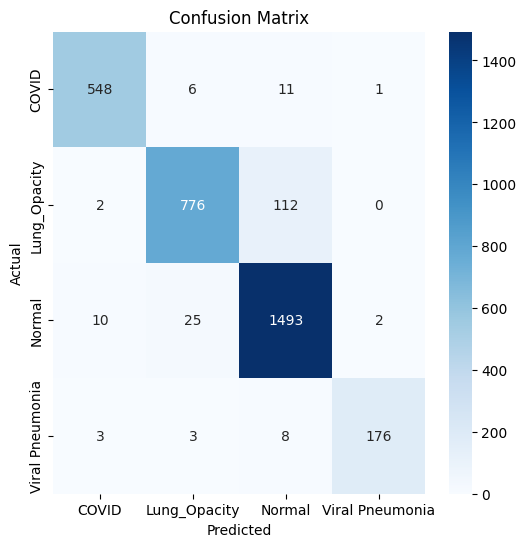

Classification Report:
                  precision    recall  f1-score   support

          COVID       0.97      0.97      0.97       566
   Lung_Opacity       0.96      0.87      0.91       890
         Normal       0.92      0.98      0.95      1530
Viral Pneumonia       0.98      0.93      0.95       190

       accuracy                           0.94      3176
      macro avg       0.96      0.94      0.95      3176
   weighted avg       0.94      0.94      0.94      3176



In [18]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=dataset.classes))

In [20]:
%pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 65.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
Note: you may need to restart the kernel to use updated packages.
